In [ ]:
# Put these to comment when running in your local machine.
!git clone https://github.com/NUBIVlab/HyperColorization
%cd HyperColorization
!pip install git+https://github.com/jamesbowman/openexrpython.git
!pip install kneed

<h1><strong>HyperColorization:</strong></h1>
This notebook is for displaying and regenerating the figures in the paper with your own data or datasets available online. <br>

In [2]:
# Libraries and Modules
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import pickle
import aux_funcs.noise as noise
import aux_funcs.visualization as vis
import aux_funcs.data_import as data
import aux_funcs.colorization as clr
import aux_funcs.spectral_dimensionality as dim
import aux_funcs.metrics as qm
import aux_funcs.initialization as init

Below we import the hyperspectral image and the quality metrics. If you replace hpim and lams with your own data, rest of the notebook should still run fine.

(31, 408, 408)


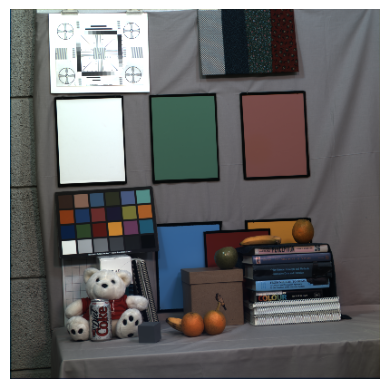

In [3]:
(lams, hpim) = data.importer.BearAndFruit_low_res()
l,h,w = hpim.shape
vis.draw_hpim(hpim, draw=True, lams = lams, method='1931')
print(hpim.shape)
metrics, hib, _ = qm.getQualityMetrics2() # hib stands for higher is better.

Below we load our spectral basis, I already have 2 basis sets learned from cave(400:10:700 nm) harvard (420:10:720 nm). If you have a new dataset replace the importer below with your own function and set reanalyze to True.

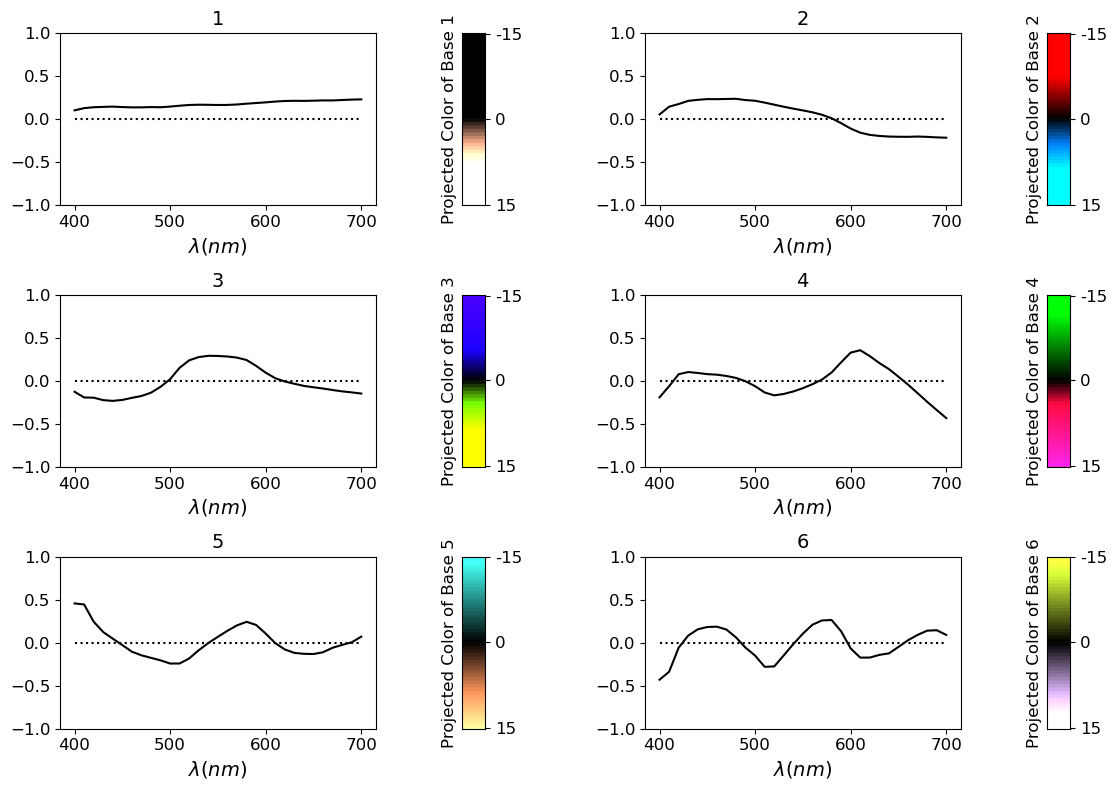

In [4]:
reanalyze = False
sd = dim.SpectralDim()
if reanalyze:
    hpim_dataset = data.importer.load_CAVE_db()
    sd.learnSpectralBasisDB(hpim_dataset,'data/spectral_basis_data.npy')
    del hpim_dataset
sd.loadSpectralBasis('data/spectral_basis_data_400-10-700.npy')
dim.drawSpectralBasis(sd, lams)

Colorization happens below. See demo.ipynb for more detailed explanation.

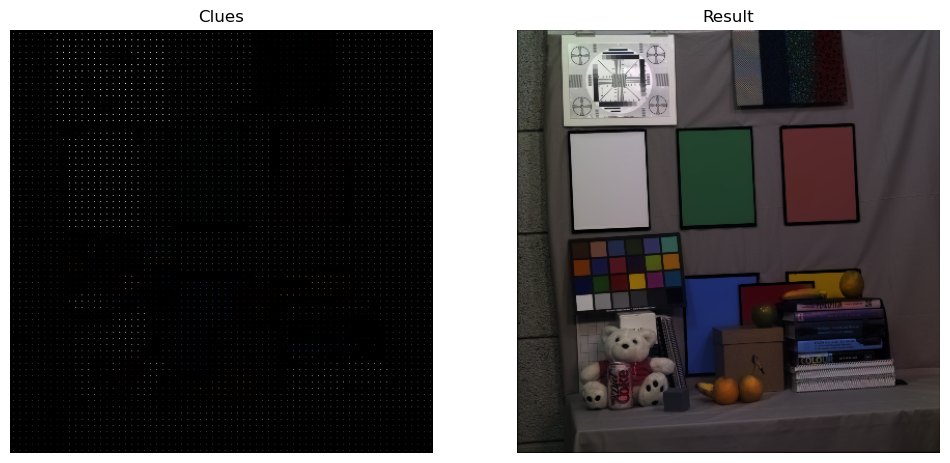

In [5]:
spectral_clues = hpim * init.get_uniform_sampling_pattern(h,w,0.03)
gray_img = np.sum(hpim, axis=0, keepdims=True)
GClr = clr.GlobalColorizer(gray_img = gray_img, visual_clues=spectral_clues, draw_method = '1931', lams = lams)
result = GClr.hyperColorize(draw_result = True)
#vis.clicker_visualization(lams, hpim, result, name1 = 'GT', name2 = 'Reconstruction') # This is for interactive visualization, disabled on collab. 

Below we simulate colorization with different exposure times, and in different dimensional spaces. The run time is 80 minutes for a 512x512 image on my laptop.

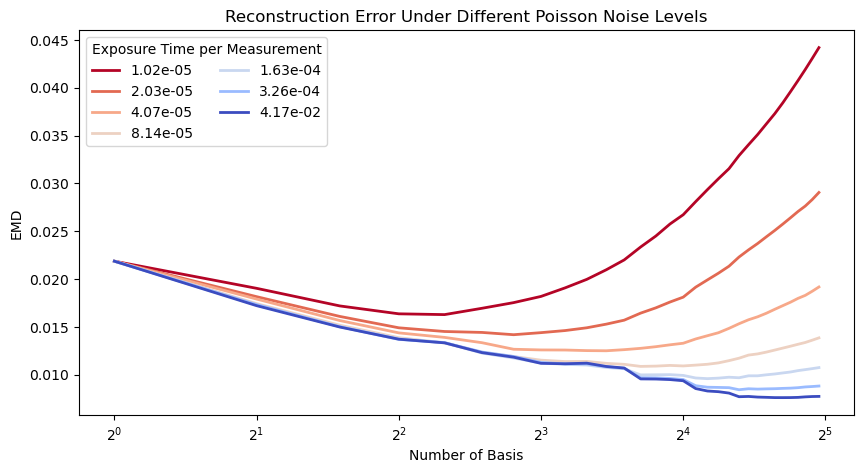

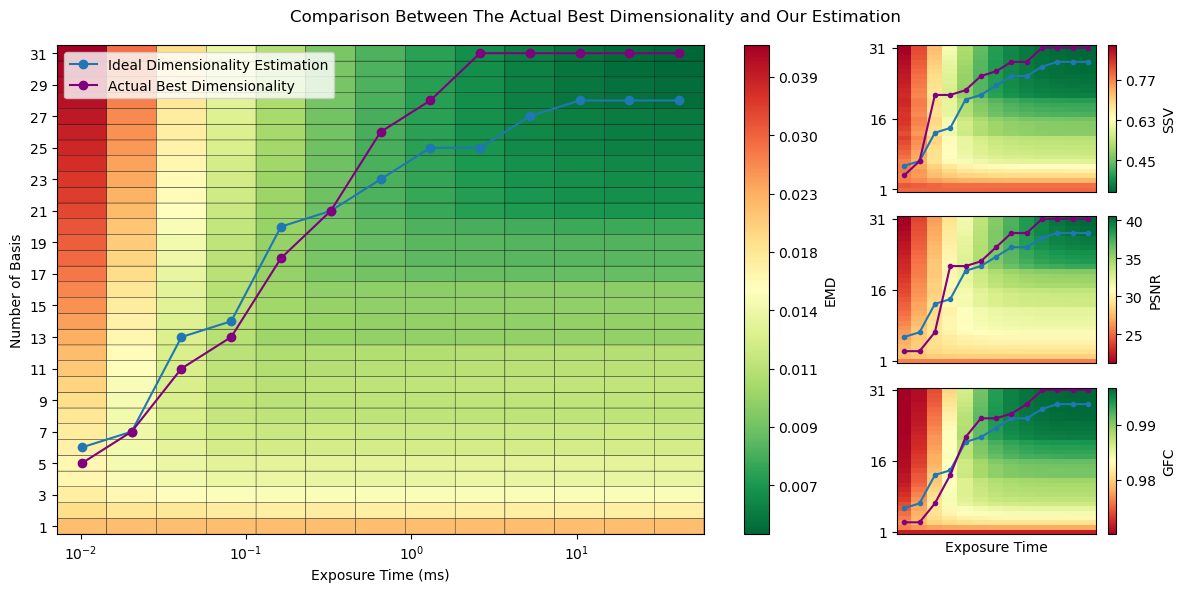

In [5]:
reanalyze = False
redraw = True
if reanalyze:
    ideal_dim_output = dim.analysisForPaper(hpim, 13, sd, GClr, metrics)
    file = 'data/analysis_output.pickle'
    with open(file, 'wb') as f:
        pickle.dump(ideal_dim_output, f)
if redraw:
    f = open('data/analysis_output.pickle', 'rb')
    ideal_dim_output = pickle.load(f)
    dim.dimensionalityFigures(ideal_dim_output, 'EMD')
    f.close()

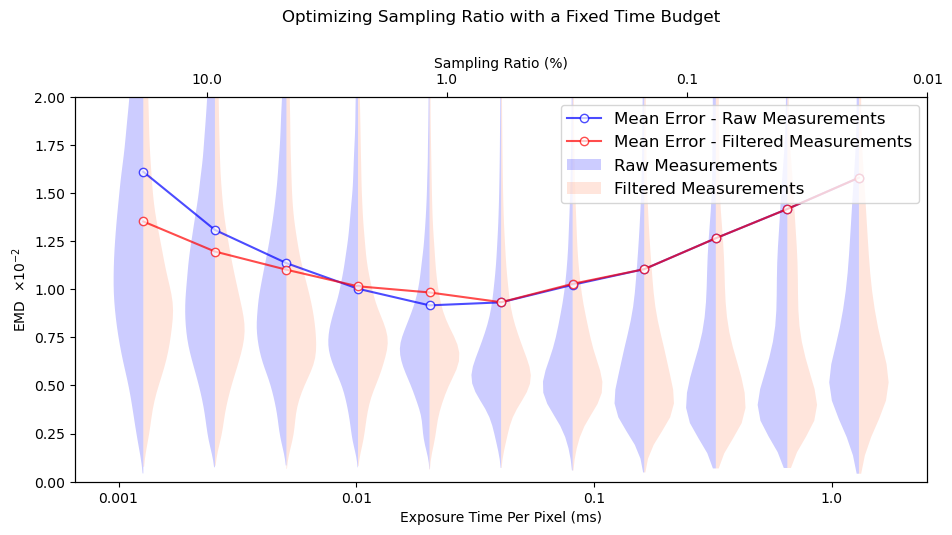

In [6]:
reanalyze = False
redraw = True
if reanalyze:
    rec_dims = np.asarray([5,7,11,13,18,21,26,28,31,31,31])
    constant_time_output, raw_data = init.ShotNoiseClueCountTrade(hpim, 11, sd, GClr, metrics, rec_dim=rec_dims)
    file = 'data/analysis2_output.pickle'
    raw_file = 'data/analysis2_output.npy'
    with open(file, 'wb') as f:
        pickle.dump(constant_time_output, f)
    np.save(raw_file, raw_data)
if redraw:
    raw_data = np.load("data/analysis2_output.npy")
    f = open('data/analysis2_output.pickle', 'rb')
    constant_time_output = pickle.load(f)
    init.constantTimeViolinFigure(constant_time_output,raw_data, 'EMD', y_range = (0, 2.0))
    f.close()